<a href="https://colab.research.google.com/github/venushagan/vhagan_225a/blob/main/bms225a_ds_workshop2_student_notebook_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BMS-225a DS Workshop #2

## Objective
The primary objective of this workshop is to analyze single-cell data to understand the distribution of cell types across different patient samples, and prepare a processed dataset that can be used to reproduce Fig.2e in Mennillo et al. 2024:

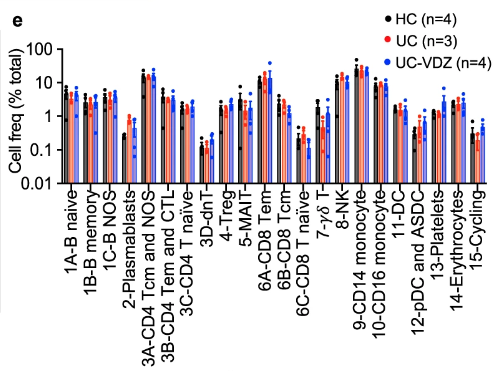




Mennillo, E., Kim, Y.J., Lee, G. et al. Single-cell and spatial multi-omics highlight effects of anti-integrin therapy across cellular compartments in ulcerative colitis. Nat Commun 15, 1493 (2024). https://doi.org/10.1038/s41467-024-45665-6

## Workflow Summary
We will start with a DataFrame containing information about diffenrent cell types (peripheral blood leukocytes) from multiple patients across three conditions (Healthy Controls, Ulceritive Colitis, and Ulceritive Colitis + medication). The main steps are:

1. **Data Transformation**:
    - Pivot the dataset to generate a table that shows the counts of different cell types for each patient.
    - Normalize these counts to obtain cell type proportions as percentages.

2. **Data Reshaping**:
    - Reshape the resulting dataset to facilitate downstream analysis by creating a long format, where each row represents a particular patient, cell type, and its corresponding percentage.

3. **Data Merging**:
    - Merge this reshaped data with patient-specific condition information to enable comparison between the three patient groups.

---

## import pandas and load data

In [ ]:
import pandas as pd

# (optional) Show more columns in output
pd.set_option('display.max_columns', 50)  # you can also set 'display.max_rows'

In [ ]:
### load the csv file

cell_metadata = pd.read_csv('cell_metadata.csv', index_col=0)

## STEP 0. Inspect data and prepare the dataframe we'll work with

In [ ]:
cell_metadata

Inspect the data

In [ ]:
## How many cells per patient? --> .value_counts()

cell_metadata['CoLabs_patient'].value_counts()

In [ ]:
# How many unique values in these columns? --> .nunique()

cell_metadata[['CoLabs_patient', 'MK final coarse_V2',	'condition']].nunique()

In [ ]:
# Group by example: average number of reads per sample id

index_columns=['CoLabs_ID']
values_column = 'nCount_RNA'
aggregation_function = 'mean'

cell_metadata.groupby(index_columns)[values_column].agg(aggregation_function)

In [ ]:
# save the above result to a new variable
average_reads = cell_metadata.groupby(index_columns)[values_column].agg(aggregation_function) ## same function as above

In [ ]:
average_reads.describe()

In [ ]:
# we can also calculate mean and std directly by using .mean() and .std()
mu=average_reads.mean()
sigma=average_reads.std()

In [ ]:
# outliers ?
average_reads[ (average_reads>mu + 2*sigma) | (average_reads<mu - 2*sigma)]

In [ ]:
# we can also compute it like this:
average_reads[ (average_reads - mu).abs() > 2*sigma ]

In [ ]:
#If we want we can remove these ids from our data
keep = average_reads[ (average_reads - mu).abs() < 2*sigma ].index
filtered_cell_metadata = cell_metadata[ cell_metadata['CoLabs_ID'].isin(keep) ]

In [ ]:
filtered_cell_metadata

In [ ]:
# if we decide to filter:
# cell_metadata = filtered_cell_metadata.copy()

In [ ]:
cell_metadata.head()

> For reproducing Fig.2e, we only need the columns `CoLabs_patient`, `MK final coarse_V2`, and  `condition` from this DataFrame

In [ ]:
### select these columns from adata.obs and assign the result to a new dataframe, lets call it cell_df
relevant_columns = ['CoLabs_patient', 'MK final coarse_V2', 'condition']


#####################################




#####################################

In [ ]:
cell_df

In [ ]:
### rename these columns for clarity. We can use the .rename() function that takes as input a dictionary (columns parameter)
rename_dictionary = {'CoLabs_patient' : 'patient',
                     'MK final coarse_V2': 'cell_type'}


##########################################################################




##########################################################################

In [ ]:
cell_df

In [ ]:
# @title Compact version of what we are going to do today
def get_cell_type_percentages(obs, sample_column, celltype_column, condition_column):
  return (
          obs.pivot_table(
                index=sample_column,
                columns=celltype_column,
                aggfunc='size',
                observed=True,
                fill_value=0) # Pivot table to get counts
          .pipe(lambda df: df.div(df.sum(axis=1)/100, axis=0)) # Normalize rows to sum to 100
          .unstack() # Reshape to long format
          .rename('cell_type_pct') # Rename the resulting column
          .reset_index() # Reset the index
          .merge(obs[[sample_column, condition_column]].drop_duplicates(subset=sample_column),
                  on=sample_column)  # Merge condition data
         )

### Call the function:
get_cell_type_percentages(obs=cell_df,
                          sample_column='patient',
                          celltype_column='cell_type',
                          condition_column = 'condition')

## STEP 1. Count the number of cells within each celltype for each individual patient

### Understanding our usecase of pivot table

Here we will create an toy dataset that is unrelated to the one we are working on, just for illustration purposes

In [ ]:
## Example dataset for illustration purposes
example_data = pd.DataFrame({
    'patient': ['P1', 'P1', 'P1', 'P2', 'P2', 'P3', 'P3', 'P3', 'P4', 'P4'],
    'cell_type': ['T-cell', 'B-cell', 'T-cell', 'T-cell', 'NK-cell', 'B-cell', 'B-cell', 'NK-cell', 'T-cell', 'T-cell']
}).astype('category')
example_data

In [ ]:
#Pivot_table function
example_data.pivot_table(index='patient', columns='cell_type', aggfunc='size',)

- The `pivot_table()` function combines the `groupby` and `pivot` functions. We can get the same result with:
```
example_data.groupby(['patient','cell_type']).size().reset_index().pivot(index='patient',columns = 'cell_type')
```

- Here we use `pivot_table()` to count. This function can do more (see: pandas guide for [pivot-table](https://pandas.pydata.org/docs/getting_started/intro_tutorials/07_reshape_table_layout.html#pivot-table))

### A) Pivot table to get `cell_type_counts`

In [ ]:
# Pivot table usage:
# DataFrame.pivot_table(
#     index=???,
#     columns=???,
#     aggfunc=???)

### use the pivot_table function to create a new dataframe (lets call it cell_type_counts) that counts the
### number of cells for each cell_type-patient combination.

########################################################





########################################################

In [ ]:
cell_type_counts

### B) Normalize to get `cell_type_percentages`

In this section we want to normalize the rows of the above `cell_type_counts` dataframe to get percentages.

We are going to do it in two steps:
- calculate the row sums of `cell_type_counts` (using `.sum()`)
- divide the rows of `cell_type_counts` by the row sums (using `.div()`) and multiply the result by 100.

In [ ]:
# Here is how you can get more info about a function:
cell_type_counts.sum?

In [ ]:
### use the .sum() function to get the total patient counts (sum over all cell types)
### lets name the result total_patient_counts

#############################################




#############################################

In [ ]:
### use .div() to divide each row of the cell_type_counts by its row sums (total_patient_counts).
### Multiply the entire table by 100 to get percentages
### lets call the result cell_type_percentages.

# DataFrame.div() takes two parameters as input:
#     1. a column (or row) with numerical values, and
#     2. an axis parameter to specify whether to do the div per 'row' (or 'column')


#####################################################################################




#####################################################################################

In [ ]:
cell_type_percentages

In [ ]:
# # Extra: quick plot to visualize cell_type percentages across patients (stacked barplot)
cell_type_percentages.plot(kind='bar',stacked=True,).legend(bbox_to_anchor=(1,1))

## STEP 2. Reshape back to long format

In [ ]:
cell_type_percentages.head() # head returns the top 5 rows of the dataframe. It is useful for quickly inspecting the data without overflowing the output display

### `unstack`, `rename` and `reset_index`

In [ ]:
## use the unstack() function to reshape the 2D table to 1D (long format).
## Ok to overwrite the same cell_type_percentages dataframe

##############################################################




##############################################################

In [ ]:
cell_type_percentages # unstacked

- This returned a **single column** (named 0). The rows are indexed by the combination of cell_type and patient (**MultiIndex**)

In [ ]:
## The above column created by unstack() is named '0'. Lets rename it to something more meaningful.
## Since there is only one column we won't need a dictionary (as we did in STEP 0)
## just call .rename with a name of your choice.

## Ok to overwrite the same cell_type_percentages dataframe

######################################################################




######################################################################

In [ ]:
cell_type_percentages # column renamed

In [ ]:
## Also the index has multiple levels (MultiIndex [cell_type, patient]).
## Lets reset it by using the .reset_index() function!
## Ok to overwrite the same cell_type_percentages dataframe

######################################################################




######################################################################

In [ ]:
cell_type_percentages # index was reset and the 'cell_type' and 'patient' were added to the columns

## STEP 3. Add  patient-specific condition information by merging on the patient column

In [ ]:
#remember cell_df? It has the information we need!
cell_df

In [ ]:
## Create a dataframe (lets call it patient_to_condition) by selecting the two columns from cell_df
## and calling the function .drop_duplicates(). Let's do both of these in the same line of code
select_columns = ['patient','condition']

######################################################################




######################################################################

In [ ]:
patient_to_condition

> Note that this works for our purposes because we know that each patient maps to one and only condition. We can check if this is the case with: `patient_to_condition.groupby('patient').size().max()`

In [ ]:
cell_type_percentages.head()

### Let's `merge`

In [ ]:
## It looks like we can merge the two by joining them on their common column "patient"
## Lets use the .merge() function on the cell_type_percentages dataframe with input patient_to_condition

## Ok to overwrite the same cell_type_percentages dataframe

######################################################################




######################################################################

Note that:
- The `merge()` function would throw an error if there were no common columns between the two dataframes.
- If the two dataframes had more than one column in common, the functions behavior defaults to using the intersection of the columns in both dataframes.
- It is a good practice to specify which column to use with the `merge(...,on='some_column')`.


---

In [ ]:
cell_type_percentages

## Save the processed file

In [ ]:
cell_type_percentages.to_csv('patient_cell_type_percentages_with_condition.csv')

In [ ]:
# You can now go to the files tab to download your file
# Push this csv file and save this notebook to your github

# Done!